# Section 5.4: Linear ODE system with four unknown parameters

This notebook reproduces the analyses in Section 5.4 of the manuscript, including Figure 6. 

## Setup 

We load the Julia environment specified in the `Project.toml` and `Manifest.toml` files: First, we activate this environment, then install all dependencies (if some packages are not yet installed), and print out which packages and versions are currently in our environment: 

In [1]:
using Pkg;

# all paths are relative to the `notebook` subfolder main folder, i.e., assuming `pwd()` outputs
# ".../DeepDynamicodelingWithJust2TimePoints/notebooks"

Pkg.activate("../.")
Pkg.instantiate()
Pkg.status()

  Activating environment at `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`


      Status `~/Desktop/DeepDynamicModelingWithJust2TimePoints/Project.toml`
  [6e4b80f9] BenchmarkTools v1.2.1
  [336ed68f] CSV v0.9.10
  [a93c6f00] DataFrames v1.2.2
  [aae7a2af] DiffEqFlux v1.44.0
  [31c24e10] Distributions v0.25.24
  [587475ba] Flux v0.12.8
  [033835bb] JLD2 v0.4.15
  [b964fa9f] LaTeXStrings v1.3.0
  [1dea7af3] OrdinaryDiffEq v5.65.5
  [91a5bcdd] Plots v1.23.5
  [112f6efa] VegaLite v2.6.0
  [9a3f8284] Random


Next, we load and precompile the necessary packages (in the versions specified by the `*.toml` files). 

In [2]:
using Distributions
using Random
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
gr()

Plots.GRBackend()

Additionally, we import some user-defined functions, with different files for separate functionality.

In [3]:
include("../src/simulation.jl") # for simulating data
include("../src/model.jl") # for initializing and training the model
include("../src/batches.jl") # for using batches of similar individuals for training 
include("../src/plotting.jl") # for plotting data and learned trajectories

plot_batch_solution (generic function with 1 method)

## Data generation

First, we define the ground-truth developments as solutions of the underlying two-dimensional linear ODE system with two distinct sets of parameters, corresponding to two groups of individuals with two distinct underlying development patterns. 

In [4]:
# define initial condition
true_u0 = Float32[4, 2]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.1, 0.1, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.1, -0.1, 0.25]

# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)
  
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);

Now, we simulate data of `n`$=100$ individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(here: $1.5$) and `t_end` (here: $10$) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p`$/2$ measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p`$=10$ variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

The simulation design also allows for generating data at more than two time points, which can be set with the `maxntps` option specifying the maximum number of timepoints after the baseline visit. If `maxntps`$>1$, for each individual, a random number of time points between $1$ and `maxntps` is drawn, corresponding to the number of measurement time point available for that individual. 

In our current setting, we set $\sigma_{\mathrm{ind}} = 0.5$ and $\sigma_{\mathrm{var}} = 0.1$. 

In [5]:
# define numbers of individuals and variables 
n = 100
p = 10
q, q_info = 50, 20

# set seed for reproducibility
Random.seed!(12)

# generate time-dependent and baseline variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2; maxntps=1, σ_var=0.1, σ_ind=0.5); # default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5
x_baseline = generate_baseline_4params(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2); # defaul vals: σ_info=0.1, σ_noise=0.1
data = simdata(xs, x_baseline, tvals, group1, group2);

We can now look at the data we generated (dots) and the true trajectories (solid lines): The plot shows the true ODE solutions as lines in the first row and the solutions and drawn measurements as dots in the second row, separately for each group (=column).

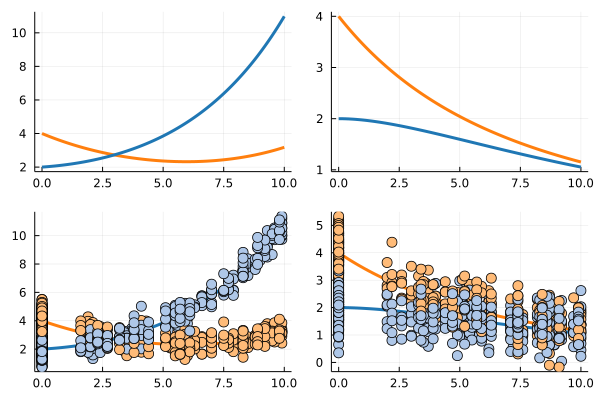

In [6]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false
)

## Define and train model 

Next, we define the architecture of our model and initialize the model (with random weights). Additionally, we specify the batch size and the kernel for weighting individuals according to similarity for the extension of the approach based on training on batches of similar individuals. 

In [7]:
zdim = 2
nODEparams = 4
m = init_vae(p, q, zdim, nODEparams, prob1, seed=550) # 543
batchsize = 10
kernel=tricube

tricube (generic function with 1 method)

We specify the model loss, the optimizer and the learning rate for the stochastic gradient descent as well as a callback function to look at the learned trajectories of exemplary individuals during training. 

In [8]:
opt = ADAM(0.0005) # 0.001
nepochs = 10

L = batchloss_wrapper(m)
ps = getparams(m)

evalcb_zs() = eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt)

evalcb_zs (generic function with 1 method)

Now, it's time to start training!

┌ Info: epoch 
│   epoch = 1
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 86.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 84.889 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 85.444 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


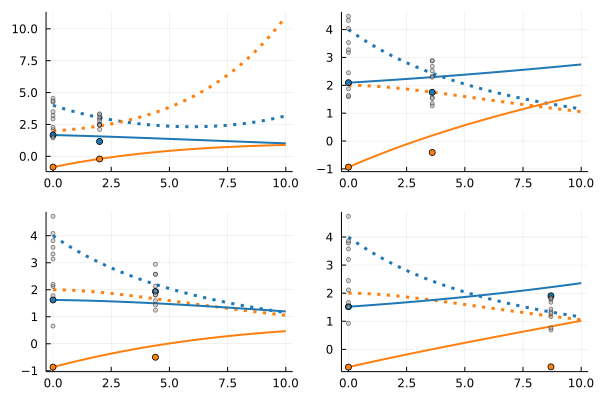

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 114.72032349133717


┌ Info: epoch 
│   epoch = 2
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 70.889 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 70.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 70.444 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


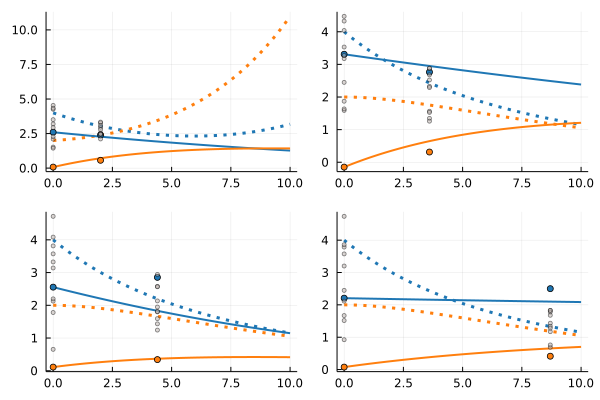

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 76.69330837162465


┌ Info: epoch 
│   epoch = 3
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 69.111 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 70.667 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 69.889 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


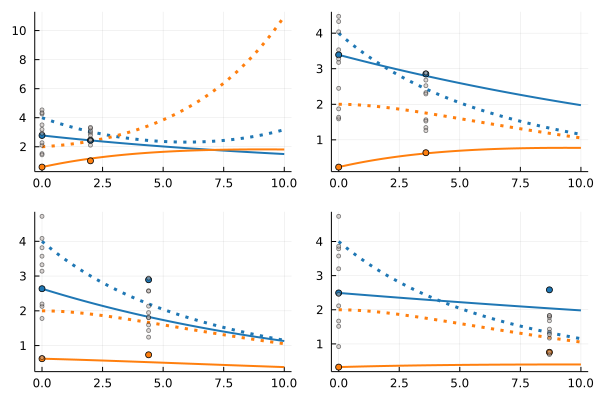

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 62.362162176265926


┌ Info: epoch 
│   epoch = 4
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 91.778 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 88.222 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 90.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


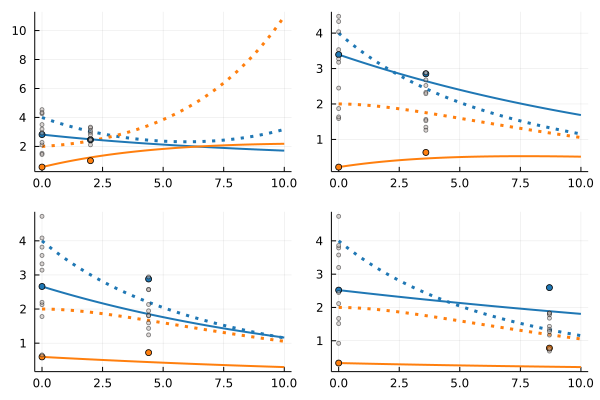

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 55.427915468735875


┌ Info: epoch 
│   epoch = 5
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 99.111 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 95.333 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 97.222 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


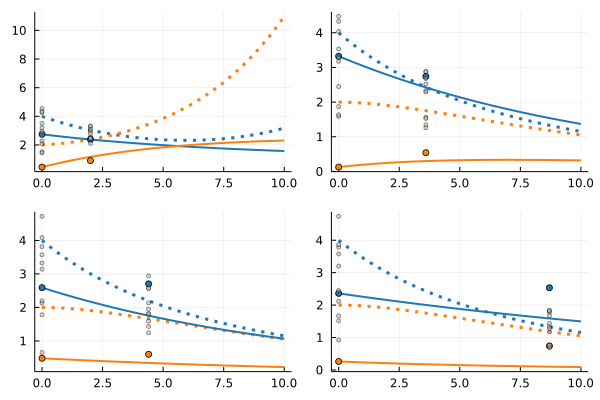

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 49.981711170883976


┌ Info: epoch 
│   epoch = 6
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 98.444 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 99.222 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


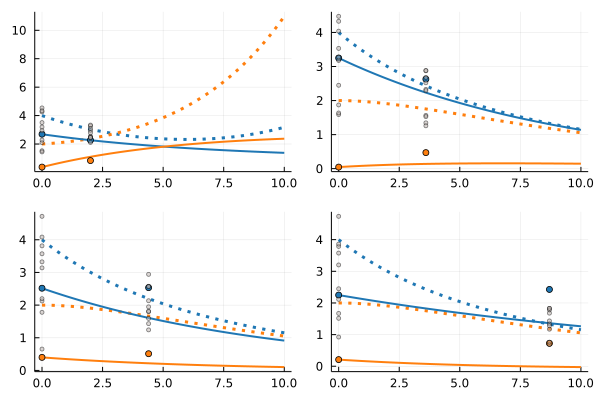

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 46.597261052801414


┌ Info: epoch 
│   epoch = 7
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 99.778 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 99.889 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


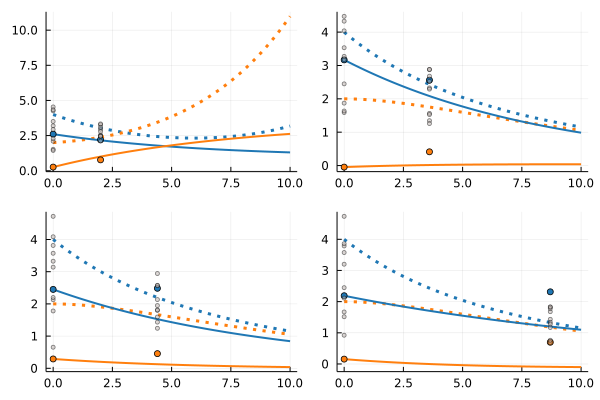

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 43.87564146364812


┌ Info: epoch 
│   epoch = 8
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


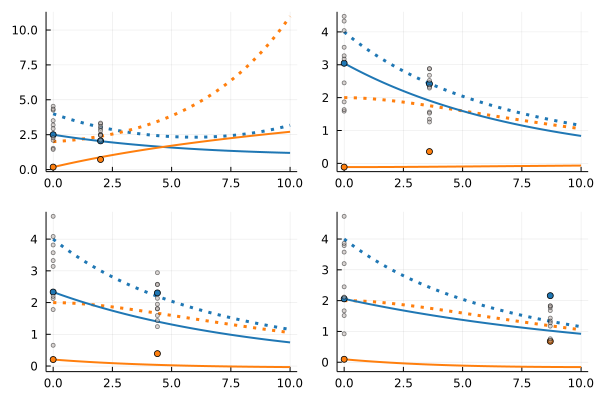

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 41.966300402588914


┌ Info: epoch 
│   epoch = 9
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


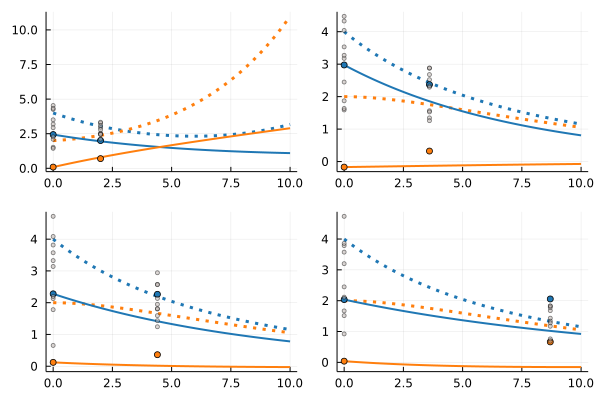

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 39.995886880304035


┌ Info: epoch 
│   epoch = 10
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:8
┌ Info: group1 : 100.0 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:9
┌ Info: group2 : 99.778 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:10
┌ Info: in total 99.889 correctly classified
└ @ Main /Users/imbi-mac-102/Desktop/DeepDynamicModelingWithJust2TimePoints/notebook/Sec5-4_LinearODEwith4Parameters.ipynb:11


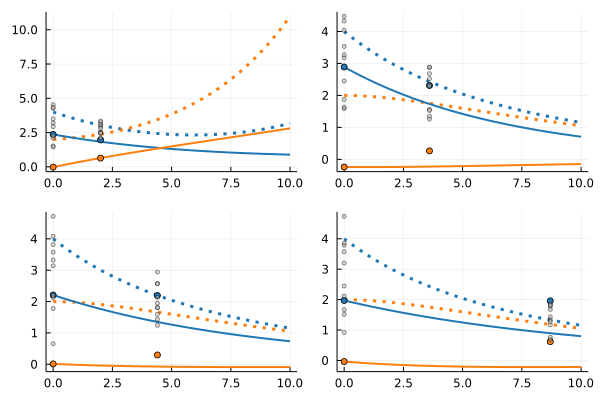

mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)) = 38.40868517694036


In [9]:
numbers_of_correctly_classified = []

for epoch in 1:10
    distmat = getdistmat_odesols_mean(m, xs, x_baseline; centralise=true);
    minibatches, batch_weights = findminibatches_distmat(distmat, batchsize, kernel);
    #minibatches, batch_weights = randomminibatches(x_baseline,batchsize)
    corr_class_g1, corr_class_g2, corr_class_total  = evaluate_minibatches_pergroup(minibatches,group1,group2);
    @info "epoch " epoch
    @info "group1 : $(round(corr_class_g1, digits=3)) correctly classified"
    @info "group2 : $(round(corr_class_g2, digits=3)) correctly classified"
    @info "in total $(round(corr_class_total, digits=3)) correctly classified"
    batch_xs = collect(xs[minibatches[i]] for i in 1:length(xs));
    batch_x_baseline = collect(x_baseline[minibatches[i]] for i in 1:length(x_baseline));
    batch_tvals = collect(tvals[minibatches[i]] for i in 1:length(tvals));
    batchdata = zip(batch_xs, batch_x_baseline, batch_tvals, batch_weights);
    push!(numbers_of_correctly_classified,[corr_class_g1, corr_class_g2, corr_class_total])
    Flux.train!(L, ps, batchdata, opt)
    @show(mean(L.(batch_xs, batch_x_baseline, batch_tvals, batch_weights)))
    evalcb_zs()
end

## Visualize results 

Finally, we can look at the results to evaluate what our model has learnt. 

We plot two individual solutions, one from each group, as well as the solutions across all individuals in each group. This reproduces the four panels of Figure 4. 

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


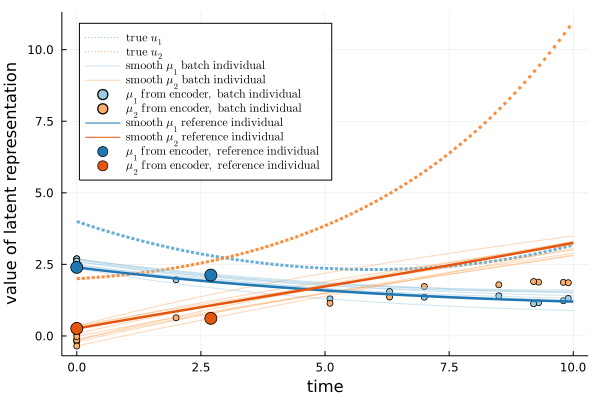

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


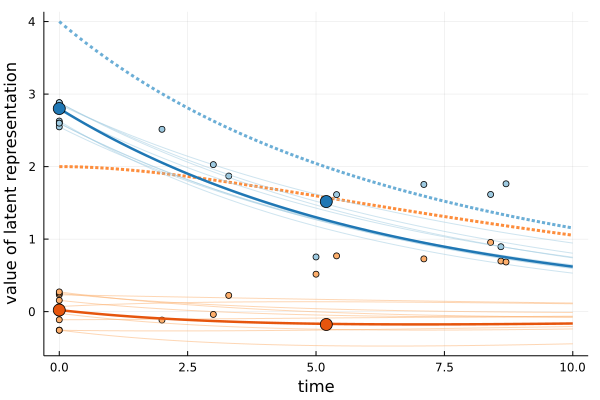

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


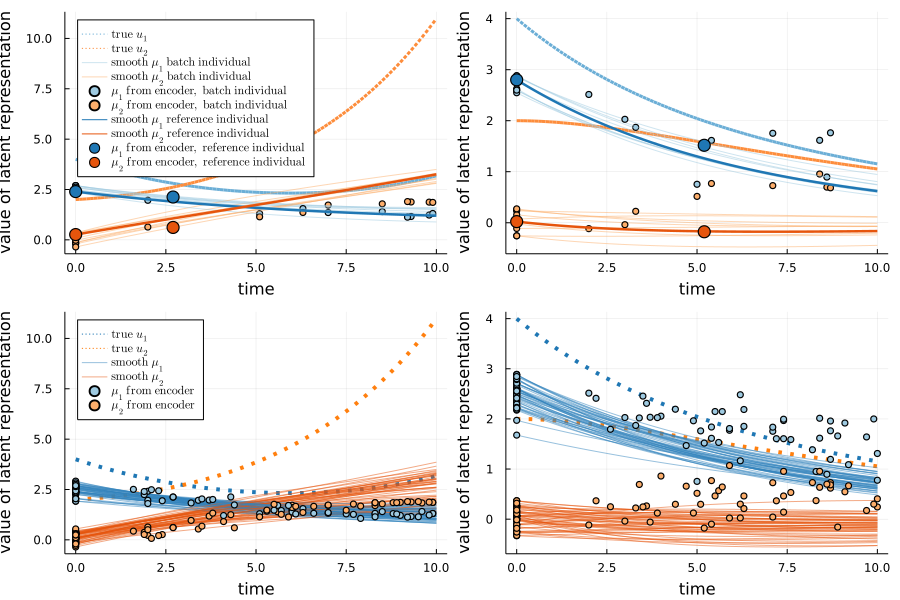

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


In [10]:
# individual plots 
p1 = plot_batch_solution(66, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt)
p2 = plot_batch_solution(87, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, showlegend=false)

p3 = allindsplot(2, data, m, sol_group1, sol_group2)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, showlegend=false)

display(plot(p1, p2, p3, p4, layout=(2,2), size=(900,600)))

Additionally, we can save the figures in the `figures` subfolder. 

In [13]:
# save results 
savefig(p1, "../figures/Figure6_topleft.pdf")
savefig(p2, "../figures/Figure6_topright.pdf")
savefig(p3, "../figures/Figure6_bottomleft.pdf")
savefig(p4, "../figures/Figure6_bottomright.pdf")

┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132


┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
┌ Warning: Indices Base.OneTo(2) of attribute `linestyle` does not match data indices 1:101.
└ @ Plots /Users/imbi-mac-102/.julia/packages/Plots/1RWWg/src/utils.jl:132
